# Graded Challenge 2
Izzan Dienurrahman
HCK-003

# Problem 1 (Stats)

## Description

### Objective
- Menganalisa sistem pembuangan dan pengelolaan sampah di kota Austin guna memberikan insight kepada pemerintah kota setempat mengenai kondisi sistem pembuangan dan pengelolaan sampah.


### Problem Statement
- Melihat jumlah site pembuangan sampah
- Melihat semua jenis sampah
- Menganalisa dan membandingkan central tendency banyaknya sampah baik sampah yang dipisahkan jenisnya maupun tidak
- Menganalisa karakteristik distribusi besarnya sampah baik sampah yang dipisahkan jenisnya maupun tidak
- Menganalisa dan menghandle outlier pada dataset
- Menentukan keputusan kapasitas site baru berdasarkan data
- Menganalisa signifikansi kapasitas pembuangan sampah antar site pembuangan sampah

## SQL Query
>SELECT
report_date,
load_time,
load_type,
load_weight,
dropoff_site  
FROM `bigquery-public-data.austin_waste.waste_and_diversion` 
WHERE report_date >= '2021-01-01' AND report_date < '2022-01-01'
ORDER BY report_date

## Data Loading

In [1]:
# import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
import pylab

In [2]:
pd.options.display.float_format = "{:,.2f}".format # mengatur pemisah angka ribuan dan 2 angka dibelakang koma

In [3]:
# add custom missing values
missing_values = ["n/a", "na", "--"]

In [4]:
# read dataset with added custom missing values
df = pd.read_csv('h8dsft_P0GC2_Izzan.csv', na_values=missing_values)

In [5]:
df.head() # menampilkan 5 data teratas

,report_date,load_time,load_type,load_weight,dropoff_site
0,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,NaN,ONION CREEK
1,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,NaN,ONION CREEK
2,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,NaN,ONION CREEK
3,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,NaN,ONION CREEK
4,2021-01-02,2021-01-02 09:24:00 UTC,TIRES,"1,640.00",MRF


In [6]:
df.tail() # menampilkan 5 data terbawah

,report_date,load_time,load_type,load_weight,dropoff_site
26152,2021-07-09,2021-07-09 09:48:00 UTC,BRUSH,"8,240.00",HORNSBY BEND
26153,2021-07-09,2021-07-09 12:02:00 UTC,BRUSH,"4,160.00",HORNSBY BEND
26154,2021-07-09,2021-07-09 11:55:00 UTC,BRUSH,"4,340.00",HORNSBY BEND
26155,2021-07-09,2021-07-09 12:00:00 UTC,LITTER,"1,900.00",TDS LANDFILL
26156,2021-07-09,2021-07-09 12:00:00 UTC,LITTER,"3,040.00",TDS LANDFILL


## Data Cleaning

In [7]:
df.info() # menampilkan info mengenai dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26157 entries, 0 to 26156
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   report_date   26157 non-null  object 
 1   load_time     26157 non-null  object 
 2   load_type     26157 non-null  object 
 3   load_weight   25109 non-null  float64
 4   dropoff_site  26157 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1021.9+ KB


Terdapat 26157 total entri data, dimana semua kolom memiliki entri yang penuh terisi kecuali kolom "load_weight"

In [8]:
df.isnull().sum() # menampilkan jumlah missing value berdasarkan tiap kolomnya

report_date        0
load_time          0
load_type          0
load_weight     1048
dropoff_site       0
dtype: int64

Terlihat adanya 1048 missing values pada kolom load_weight

Skewness value :  3.335938213321684


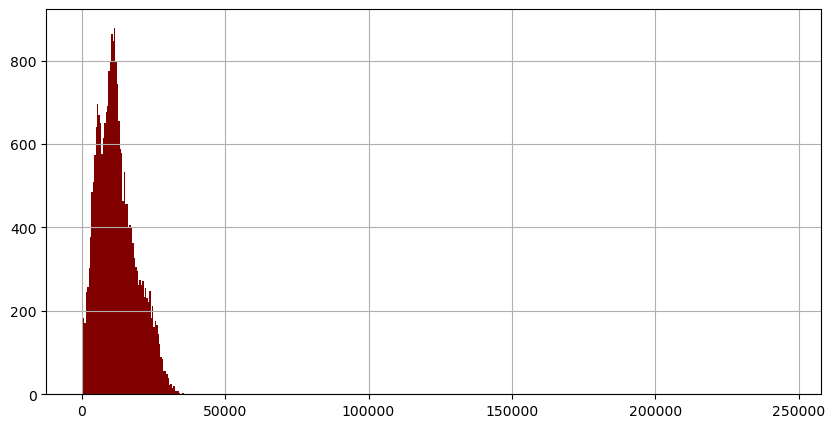

In [9]:
df['load_weight'].hist(bins=500, figsize=(10,5), color='maroon')
print('Skewness value : ', df['load_weight'].skew())

Nilai kemiringan/skewness > 1 yang berarti fitur tersebut sangatlah miring (highly skewed) yang berarti mengisi missing valuesnya dengan nilai median.

In [10]:
df['load_weight'].fillna(df['load_weight'].median(), inplace=True) # mengisi missing value dengan nilai median kolom/fitur tersebut

In [11]:
df.isnull().sum() # menampilkan jumlah missing value berdasarkan tiap kolomnya

report_date     0
load_time       0
load_type       0
load_weight     0
dropoff_site    0
dtype: int64

Terlihat sudah tidak ada missing values, dan data siap di eksplorasi.

## Data Exploration

Menampilkan semua jenis sampah dari dataset

In [12]:
pd.DataFrame(df['load_type'].unique())

,0
0,SWEEPING
1,TIRES
2,RECYCLING - SINGLE STREAM
3,YARD TRIMMING
4,BULK
5,DEAD ANIMAL
6,GARBAGE COLLECTIONS
7,MIXED LITTER
8,ORGANICS
9,BRUSH


Menampilkan semua lokasi pembuangan sampah

In [13]:
pd.DataFrame(df['dropoff_site'].unique())

,0
0,ONION CREEK
1,MRF
2,TDS - MRF
3,HORNSBY BEND
4,TDS LANDFILL
5,ORGANICS BY GOSH
6,BALCONES RECYCLING
7,AUSTIN IRON AND METAL
8,PARK CENTER
9,ON ROUTE HIGH DUMP


Menampilkan jenis sampah yang ada pada tiap lokasi pembuangan sampah

In [14]:
df[['dropoff_site','load_type']].groupby(['dropoff_site','load_type']).sum()

Empty DataFrame
Columns: []
Index: [(AUSTIN IRON AND METAL, RECYCLED METAL), (AUSTIN WOOD RECYCLING, RECYCLING - SINGLE STREAM), (BALCONES RECYCLING, RECYCLING - SINGLE STREAM), (BALCONES WOODS, RECYCLING - SINGLE STREAM), (GREAT NORTHERN, GARBAGE COLLECTIONS), (GREAT NORTHERN, SWEEPING), (HORNSBY BEND, BRUSH), (HORNSBY BEND, GARBAGE COLLECTIONS), (HORNSBY BEND, ORGANICS), (HORNSBY BEND, YARD TRIMMING), (MRF, BULK), (MRF, RECYCLED METAL), (MRF, TIRES), (ON ROUTE HIGH DUMP, ORGANICS), (ON ROUTE HIGH DUMP, SWEEPING), (ONION CREEK, SWEEPING), (ORGANICS BY GOSH, DEAD ANIMAL), (ORGANICS BY GOSH, GARBAGE COLLECTIONS), (ORGANICS BY GOSH, ORGANICS), (ORGANICS BY GOSH, RECYCLED METAL), (ORGANICS BY GOSH, SWEEPING), (PARK BEND, ORGANICS), (PARK CENTER, SWEEPING), (ST. EDWARDS, SWEEPING), (STEINER LANDFILL, GARBAGE COLLECTIONS), (TDS - MRF, BULK), (TDS - MRF, GARBAGE COLLECTIONS), (TDS - MRF, LITTER), (TDS - MRF, RECYCLING - SINGLE STREAM), (TDS LANDFILL, BRUSH), (TDS LANDFILL, BULK), (TDS LANDFILL, CONTAMINATED ORGANICS), (TDS LANDFILL, CONTAMINATED RECYCLING), (TDS LANDFILL, DEAD ANIMAL), (TDS LANDFILL, GARBAGE COLLECTIONS), (TDS LANDFILL, LITTER), (TDS LANDFILL, MIXED LITTER), (TDS LANDFILL, ORGANICS), (TDS LANDFILL, RECYCLED METAL), (TDS LANDFILL, RECYCLING - SINGLE STREAM), (TDS LANDFILL, SWEEPING), (TDS LANDFILL, TIRES), (WESTFIELD, GARBAGE COLLECTIONS), (WILCAB, SWEEPING)]

Menampilkan akumulasi sampah pada tiap lokasi pada periode (01 Januari - 19 Juli 2021).

In [15]:
df[['dropoff_site','load_weight']].groupby('dropoff_site').sum()

,load_weight
dropoff_site,
AUSTIN IRON AND METAL,"22,560.00"
AUSTIN WOOD RECYCLING,"8,100.00"
BALCONES RECYCLING,"36,315,870.00"
BALCONES WOODS,"8,460.00"
GREAT NORTHERN,"838,120.00"
HORNSBY BEND,"10,984,420.00"
MRF,"302,397.00"
ON ROUTE HIGH DUMP,"923,880.00"
ONION CREEK,"9,186,900.00"


In [16]:
df['report_date'] = pd.to_datetime(df['report_date']) #convert report_date into pandas datetime

Menampilkan akumulasi sampah bulanan pada setiap site.

In [17]:
df_monthly = df.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M')]).sum()
df_monthly

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/3124192474.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M')]).sum()


load_weight
dropoff_site          report_date              
AUSTIN IRON AND METAL 2021-01-31       1,950.00
                      2021-02-28       1,890.00
                      2021-03-31       3,970.00
                      2021-04-30       3,410.00
                      2021-05-31       6,230.00
...                                         ...
TDS LANDFILL          2021-05-31  27,147,777.00
                      2021-06-30  27,708,990.30
                      2021-07-31   6,843,450.00
WESTFIELD             2021-05-31      16,020.00
WILCAB                2021-01-31      11,300.00

[84 rows x 1 columns]

Menampilkan site dengan sampah bulanan terbesar.

In [18]:
df_monthly[df_monthly['load_weight'] == df_monthly['load_weight'].max()]

,,load_weight
dropoff_site,report_date,
TDS LANDFILL,2021-06-30,"27,708,990.30"


Menampilkan site dengan sampah bulanan terkecil.

In [19]:
df_monthly[df_monthly['load_weight'] == df_monthly['load_weight'].min()]

,,load_weight
dropoff_site,report_date,
STEINER LANDFILL,2021-04-30,780.00


Menampilkan akumulasi sampah bulanan berdasarkan tipe sampah pada setiap site.

In [20]:
df_monthly_by_type = df.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M'),'load_type']).sum()
df_monthly_by_type

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/1893836703.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly_by_type = df.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M'),'load_type']).sum()


load_weight
dropoff_site          report_date load_type                       
AUSTIN IRON AND METAL 2021-01-31  RECYCLED METAL          1,950.00
                      2021-02-28  RECYCLED METAL          1,890.00
                      2021-03-31  RECYCLED METAL          3,970.00
                      2021-04-30  RECYCLED METAL          3,410.00
                      2021-05-31  RECYCLED METAL          6,230.00
...                                                            ...
TDS LANDFILL          2021-07-31  MIXED LITTER           33,220.00
                                  SWEEPING              151,880.00
                                  TIRES                   5,920.00
WESTFIELD             2021-05-31  GARBAGE COLLECTIONS    16,020.00
WILCAB                2021-01-31  SWEEPING               11,300.00

[170 rows x 1 columns]

Menampilkan site dengan sampah bulanan terbesar berdasarkan tipe sampahnya.

In [21]:
df_monthly_by_type[df_monthly_by_type['load_weight'] == df_monthly_by_type['load_weight'].max()]

,,,load_weight
dropoff_site,report_date,load_type,
TDS LANDFILL,2021-03-31,GARBAGE COLLECTIONS,"25,368,265.24"


Menampilkan site dengan sampah bulanan terkecil berdasarkan tipe sampahnya.

In [22]:
df_monthly_by_type[df_monthly_by_type['load_weight'] == df_monthly_by_type['load_weight'].min()]

,,,load_weight
dropoff_site,report_date,load_type,
ORGANICS BY GOSH,2021-04-30,DEAD ANIMAL,140.00


### Central Tendency

### Overall Central Tendency
Menampilkan nilai rata-rata, median, dan standar deviasi dari banyaknya sampah (load_weight) pada setiap site tanpa mempertimbangkan jenis sampah.

In [23]:
df_centrality = df.groupby(['dropoff_site']).agg({'load_weight':['mean','median','std']}) #overrall period centrality
df_centrality.sort_values(by=('load_weight','mean'),ascending=False) # mengurutkan site dari nilai mean tertinggi

load_weight                   
                             mean    median      std
dropoff_site                                        
WESTFIELD               16,020.00 16,020.00      NaN
TDS LANDFILL            15,168.32 14,920.00 8,590.07
PARK BEND               13,385.00 12,330.00 5,721.57
GREAT NORTHERN          11,973.14 11,300.00 2,691.89
ORGANICS BY GOSH        11,817.22 11,900.00 5,064.66
ON ROUTE HIGH DUMP      11,405.93 11,300.00 1,419.74
ST. EDWARDS             11,300.00 11,300.00      NaN
PARK CENTER             11,300.00 11,300.00     0.00
WILCAB                  11,300.00 11,300.00      NaN
ONION CREEK             11,300.00 11,300.00     0.00
TDS - MRF                9,872.55 10,330.00 4,083.63
BALCONES RECYCLING       9,464.65  9,840.00 3,862.24
BALCONES WOODS           8,460.00  8,460.00      NaN
HORNSBY BEND             6,637.11  6,400.00 3,240.84
AUSTIN WOOD RECYCLING    4,050.00  4,050.00 2,418.31
MRF                      1,799.98  1,360.00 2,266.19
STEINER LANDFILL           780.00    780.00      NaN
AUSTIN IRON AND METAL      451.20    400.00   215.65

Menampilkan nilai rata-rata, median, dan standar deviasi banyaknya sampah (load_weight) pada setiap site dengan mempertimbangkan jenis sampah.

In [24]:
df_centrality_by_type = df.groupby(['dropoff_site','load_type']).agg({'load_weight':['mean','median','std']}) #overrall period centrality by garbage type
df_centrality_by_type

load_weight                   
                                                       mean    median      std
dropoff_site          load_type                                               
AUSTIN IRON AND METAL RECYCLED METAL                 451.20    400.00   215.65
AUSTIN WOOD RECYCLING RECYCLING - SINGLE STREAM    4,050.00  4,050.00 2,418.31
BALCONES RECYCLING    RECYCLING - SINGLE STREAM    9,464.65  9,840.00 3,862.24
BALCONES WOODS        RECYCLING - SINGLE STREAM    8,460.00  8,460.00      NaN
GREAT NORTHERN        GARBAGE COLLECTIONS         19,153.33 21,110.00 5,686.18
                      SWEEPING                    11,300.00 11,300.00     0.00
HORNSBY BEND          BRUSH                        6,241.02  6,180.00 2,788.99
                      GARBAGE COLLECTIONS          8,600.00  8,600.00      NaN
                      ORGANICS                     8,080.00  8,080.00 2,319.31
                      YARD TRIMMING               10,981.90 11,060.00 4,503.42
MRF                   BULK                        13,750.00 13,750.00 1,880.90
                      RECYCLED METAL                 230.00    230.00      NaN
                      TIRES                        1,664.65  1,360.00 1,852.85
ON ROUTE HIGH DUMP    ORGANICS                    12,525.71 14,940.00 5,027.36
                      SWEEPING                    11,300.00 11,300.00     0.00
ONION CREEK           SWEEPING                    11,300.00 11,300.00     0.00
ORGANICS BY GOSH      DEAD ANIMAL                    230.53    100.00   387.66
                      GARBAGE COLLECTIONS          7,500.00  7,500.00      NaN
                      ORGANICS                    11,854.60 11,920.00 5,028.66
                      RECYCLED METAL              12,532.00 11,040.00 6,453.89
                      SWEEPING                    15,200.00 15,200.00 1,046.52
PARK BEND             ORGANICS                    13,385.00 12,330.00 5,721.57
PARK CENTER           SWEEPING                    11,300.00 11,300.00     0.00
ST. EDWARDS           SWEEPING                    11,300.00 11,300.00      NaN
STEINER LANDFILL      GARBAGE COLLECTIONS            780.00    780.00      NaN
TDS - MRF             BULK                         9,880.00  9,880.00 8,032.73
                      GARBAGE COLLECTIONS         16,782.14 17,060.00 7,299.53
                      LITTER                         360.00    360.00      NaN
                      RECYCLING - SINGLE STREAM    9,809.48 10,300.00 3,980.50
TDS LANDFILL          BRUSH                        9,220.00  9,220.00 3,733.52
                      BULK                         8,109.11  8,030.00 3,901.35
                      CONTAMINATED ORGANICS       25,380.00 25,380.00      NaN
                      CONTAMINATED RECYCLING       5,160.00  5,160.00      NaN
                      DEAD ANIMAL                    154.73    100.00   156.06
                      GARBAGE COLLECTIONS         17,618.41 18,140.00 8,015.73
                      LITTER                       3,208.00  2,850.00 2,585.52
                      MIXED LITTER                 3,196.90  2,900.00 1,663.29
                      ORGANICS                     1,273.64    140.00 3,692.53
                      RECYCLED METAL                 220.00    220.00      NaN
                      RECYCLING - SINGLE STREAM    2,580.00  2,000.00 2,500.96
                      SWEEPING                     9,596.33  9,310.00 4,538.07
                      TIRES                        3,512.00  2,170.00 5,455.42
WESTFIELD             GARBAGE COLLECTIONS         16,020.00 16,020.00      NaN
WILCAB                SWEEPING                    11,300.00 11,300.00      NaN

### Monthly Centrality

Monthly centrality berdasarkan jenis sampah

In [25]:
df_monthly_centrality_by_type = df_monthly_by_type.groupby(['dropoff_site','load_type']).agg({'load_weight':['mean','median','std']}) #monthly centrality berdasarkan jenis sampah
df_monthly_centrality_by_type

load_weight                \
                                                         mean        median   
dropoff_site          load_type                                               
AUSTIN IRON AND METAL RECYCLED METAL                 3,222.86      3,410.00   
AUSTIN WOOD RECYCLING RECYCLING - SINGLE STREAM      4,050.00      4,050.00   
BALCONES RECYCLING    RECYCLING - SINGLE STREAM  5,187,981.43  5,944,230.00   
BALCONES WOODS        RECYCLING - SINGLE STREAM      8,460.00      8,460.00   
GREAT NORTHERN        GARBAGE COLLECTIONS           38,306.67     20,900.00   
                      SWEEPING                     180,800.00    169,500.00   
HORNSBY BEND          BRUSH                      1,350,734.29  1,483,040.00   
                      GARBAGE COLLECTIONS            8,600.00      8,600.00   
                      ORGANICS                       8,080.00      8,080.00   
                      YARD TRIMMING                501,506.67    168,560.00   
MRF                   BULK                          13,750.00     13,750.00   
                      RECYCLED METAL                   230.00        230.00   
                      TIRES                         39,238.14     34,820.00   
ON ROUTE HIGH DUMP    ORGANICS                      29,226.67     22,520.00   
                      SWEEPING                     139,366.67    141,250.00   
ONION CREEK           SWEEPING                   1,312,414.29  1,344,700.00   
ORGANICS BY GOSH      DEAD ANIMAL                      625.71        540.00   
                      GARBAGE COLLECTIONS            7,500.00      7,500.00   
                      ORGANICS                   9,700,452.29  8,702,700.00   
                      RECYCLED METAL                20,886.67     13,420.00   
                      SWEEPING                      15,200.00     15,200.00   
PARK BEND             ORGANICS                      17,846.67     20,400.00   
PARK CENTER           SWEEPING                     141,250.00    113,000.00   
ST. EDWARDS           SWEEPING                      11,300.00     11,300.00   
STEINER LANDFILL      GARBAGE COLLECTIONS              780.00        780.00   
TDS - MRF             BULK                           9,880.00      9,880.00   
                      GARBAGE COLLECTIONS           78,316.67     74,300.00   
                      LITTER                           360.00        360.00   
                      RECYCLING - SINGLE STREAM  4,087,751.43  4,655,730.00   
TDS LANDFILL          BRUSH                         18,440.00     18,440.00   
                      BULK                       1,841,925.71  1,833,200.00   
                      CONTAMINATED ORGANICS         25,380.00     25,380.00   
                      CONTAMINATED RECYCLING         5,160.00      5,160.00   
                      DEAD ANIMAL                    2,895.71      3,580.00   
                      GARBAGE COLLECTIONS       20,648,774.65 23,090,600.00   
                      LITTER                        18,331.43     16,840.00   
                      MIXED LITTER                 150,254.29    161,620.00   
                      ORGANICS                       5,604.00      1,000.00   
                      RECYCLED METAL                   220.00        220.00   
                      RECYCLING - SINGLE STREAM      2,580.00      2,000.00   
                      SWEEPING                     493,525.71    484,940.00   
                      TIRES                          8,780.00      6,260.00   
WESTFIELD             GARBAGE COLLECTIONS           16,020.00     16,020.00   
WILCAB                SWEEPING                      11,300.00     11,300.00   

                                                              
                                                         std  
dropoff_site          load_type                               
AUSTIN IRON AND METAL RECYCLED METAL                1,765.36  
AUSTIN WOOD RECYCLING RECYCLING - SINGLE STREAM     2,418.31  
BALCONES RECYCLING   

In [26]:
df_monthly_centrality_by_type.sort_values(by=('load_weight','mean'),ascending=False) # mengurutkan site dari nilai mean tertinggi

load_weight                \
                                                         mean        median   
dropoff_site          load_type                                               
TDS LANDFILL          GARBAGE COLLECTIONS       20,648,774.65 23,090,600.00   
ORGANICS BY GOSH      ORGANICS                   9,700,452.29  8,702,700.00   
BALCONES RECYCLING    RECYCLING - SINGLE STREAM  5,187,981.43  5,944,230.00   
TDS - MRF             RECYCLING - SINGLE STREAM  4,087,751.43  4,655,730.00   
TDS LANDFILL          BULK                       1,841,925.71  1,833,200.00   
HORNSBY BEND          BRUSH                      1,350,734.29  1,483,040.00   
ONION CREEK           SWEEPING                   1,312,414.29  1,344,700.00   
HORNSBY BEND          YARD TRIMMING                501,506.67    168,560.00   
TDS LANDFILL          SWEEPING                     493,525.71    484,940.00   
GREAT NORTHERN        SWEEPING                     180,800.00    169,500.00   
TDS LANDFILL          MIXED LITTER                 150,254.29    161,620.00   
PARK CENTER           SWEEPING                     141,250.00    113,000.00   
ON ROUTE HIGH DUMP    SWEEPING                     139,366.67    141,250.00   
TDS - MRF             GARBAGE COLLECTIONS           78,316.67     74,300.00   
MRF                   TIRES                         39,238.14     34,820.00   
GREAT NORTHERN        GARBAGE COLLECTIONS           38,306.67     20,900.00   
ON ROUTE HIGH DUMP    ORGANICS                      29,226.67     22,520.00   
TDS LANDFILL          CONTAMINATED ORGANICS         25,380.00     25,380.00   
ORGANICS BY GOSH      RECYCLED METAL                20,886.67     13,420.00   
TDS LANDFILL          BRUSH                         18,440.00     18,440.00   
                      LITTER                        18,331.43     16,840.00   
PARK BEND             ORGANICS                      17,846.67     20,400.00   
WESTFIELD             GARBAGE COLLECTIONS           16,020.00     16,020.00   
ORGANICS BY GOSH      SWEEPING                      15,200.00     15,200.00   
MRF                   BULK                          13,750.00     13,750.00   
WILCAB                SWEEPING                      11,300.00     11,300.00   
ST. EDWARDS           SWEEPING                      11,300.00     11,300.00   
TDS - MRF             BULK                           9,880.00      9,880.00   
TDS LANDFILL          TIRES                          8,780.00      6,260.00   
HORNSBY BEND          GARBAGE COLLECTIONS            8,600.00      8,600.00   
BALCONES WOODS        RECYCLING - SINGLE STREAM      8,460.00      8,460.00   
HORNSBY BEND          ORGANICS                       8,080.00      8,080.00   
ORGANICS BY GOSH      GARBAGE COLLECTIONS            7,500.00      7,500.00   
TDS LANDFILL          ORGANICS                       5,604.00      1,000.00   
                      CONTAMINATED RECYCLING         5,160.00      5,160.00   
AUSTIN WOOD RECYCLING RECYCLING - SINGLE STREAM      4,050.00      4,050.00   
AUSTIN IRON AND METAL RECYCLED METAL                 3,222.86      3,410.00   
TDS LANDFILL          DEAD ANIMAL                    2,895.71      3,580.00   
                      RECYCLING - SINGLE STREAM      2,580.00      2,000.00   
STEINER LANDFILL      GARBAGE COLLECTIONS              780.00        780.00   
ORGANICS BY GOSH      DEAD ANIMAL                      625.71        540.00   
TDS - MRF             LITTER                           360.00        360.00   
MRF                   RECYCLED METAL                   230.00        230.00   
TDS LANDFILL          RECYCLED METAL                   220.00        220.00   

                                                              
                                                         std  
dropoff_site          load_type                               
TDS LANDFILL          GARBAGE COLLECTIONS       6,848,622.54  
ORGANICS BY GOSH      ORGANICS                  6,644,910.22  
BALCONES RECYCLING   

Monthly centrality tanpa melihat jenis sampah

In [27]:
df_monthly_centrality = df_monthly.groupby(['dropoff_site']).agg({'load_weight':['mean','median','std']}) #monthly centrality
df_monthly_centrality.sort_values(by=('load_weight','mean'),ascending=False) # mengurutkan site dari nilai mean tertinggi

load_weight                           
                               mean        median          std
dropoff_site                                                  
TDS LANDFILL          23,172,861.79 25,748,140.00 7,436,916.57
ORGANICS BY GOSH       9,715,443.71  8,715,460.00 6,659,087.54
BALCONES RECYCLING     5,187,981.43  5,944,230.00 2,117,444.52
TDS - MRF              4,157,754.29  4,733,050.00 1,796,368.00
HORNSBY BEND           1,569,202.86  1,660,200.00   567,745.82
ONION CREEK            1,312,414.29  1,344,700.00   523,570.54
GREAT NORTHERN           167,624.00     76,860.00   157,425.62
PARK CENTER              141,250.00    113,000.00   112,717.15
ON ROUTE HIGH DUMP       131,982.86    124,300.00   103,686.47
MRF                       43,199.57     49,900.00    20,962.13
PARK BEND                 17,846.67     20,400.00     7,924.75
WESTFIELD                 16,020.00     16,020.00          NaN
WILCAB                    11,300.00     11,300.00          NaN
ST. EDWARDS               11,300.00     11,300.00          NaN
BALCONES WOODS             8,460.00      8,460.00          NaN
AUSTIN WOOD RECYCLING      4,050.00      4,050.00     2,418.31
AUSTIN IRON AND METAL      3,222.86      3,410.00     1,765.36
STEINER LANDFILL             780.00        780.00          NaN

Value NaN pada standar deviasi menunjukkan bahwa entri data pada baris tersebut hanya memiliki 1 buah entri data dan standar deviasi pada sebuah entri data tidak terdefinisi.

Menampilkan modus dari dataset

In [28]:
df.mode()

,report_date,load_time,load_type,load_weight,dropoff_site
0,2021-02-25,2021-03-05 12:00:00 UTC,GARBAGE COLLECTIONS,"11,300.00",TDS LANDFILL


## Informasi dan Insight dari Dataset

- TDS Landfill menampung paling banyak sampah dan juga jenis sampah.
- Tiap bulannya TDS Landfil rata-rata menampung sekitar 23 juta sampah.
- Dalam periode Januari-Juli 2021 Park Center dan ST.Edward menampung sampah dengan rata rata yang sama.
- Namun dalam rentang periode bulanan, Park Center dan ST.Edwards menampung sampah dengan rata rata yang jauh berbeda (13-14x lipatnya).
- Tiap bulannnya site Organic by Gosh rata-rata menampung 9,7 juta sampah organik, site penampung kedua terbanyak setelah TDS Landfill.
- Tipe sampah dengan akumulasi terbanyak dalam 1 bulan adalah 'garbage collection'.
- Sampah daur ulang metal tidak hanya ditemukan pada site "Austin Iron and Metal".
- Tanpa memisahkan jenis sampah, nilai tengah akumulasi sampah bulanan pada tiap site relatif selalu mendekati nilai rata-ratanya.
- Namun jika mempertimbangkan jenis sampahnya, terlihat beberapa nilai tengah yang timpang dengan nilai reratanya<br>contohnya seperti tipe sampah "Yard Trimming" pada site "Hornsby Bend".
- Jumlah site dengan entri terbanyak adalah TDS Landfill.
- Jumlah tipe sampah dengan entri adalah jenis sampah garbage collections. 

Pilih site yang paling menarik perhatian kamu, dan berikan alasannya.
>Menurut saya site yang paling menarik adalah TDS-LANDFILL dengan alasan site tersebut menampung paling banyak jenis sampah.

## Analisis Site TDS Landfill

### Distribusi Jenis Sampah pada Site TDS Landfill

Distribusi banyaknya sampah pada TDS Landfill (tanpa memisahkan jenis sampah)

Skewness value :  3.6954423761109436


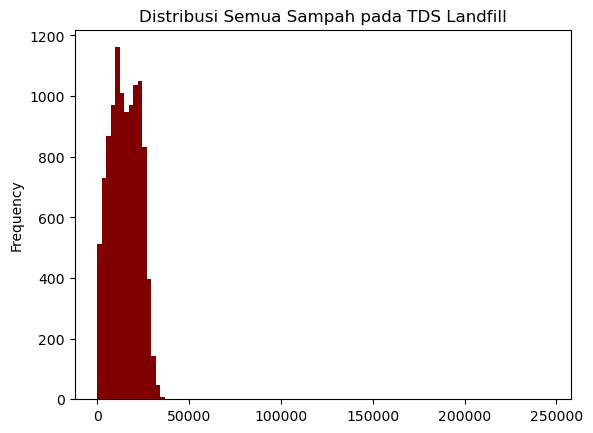

In [29]:
df.load_weight[df.dropoff_site=='TDS LANDFILL'].plot.hist(bins=100, color='maroon',title="Distribusi Semua Sampah pada TDS Landfill")
print('Skewness value : ', df.load_weight[df.dropoff_site=='TDS LANDFILL'].skew())

Distribusi banyaknya sampah pada TDS Landfill Januari-Juli 2021 dengan memperhatikan jenis sampah :

In [30]:
# simpan titles pada list
titles = df[['load_type']][df.dropoff_site=='TDS LANDFILL'].sort_values('load_type').squeeze().unique().tolist()
titles

['BRUSH',
 'BULK',
 'CONTAMINATED ORGANICS',
 'CONTAMINATED RECYCLING',
 'DEAD ANIMAL',
 'GARBAGE COLLECTIONS',
 'LITTER',
 'MIXED LITTER',
 'ORGANICS',
 'RECYCLED METAL',
 'RECYCLING - SINGLE STREAM',
 'SWEEPING',
 'TIRES']

BRUSH

Skew	: nan
Mean	: 9220.0
Median	: 9220.0
Std	: 3733.523804664971

BULK

Skew	: 0.11946100070698812
Mean	: 8109.106918238994
Median	: 8030.0
Std	: 3901.351924900931

CONTAMINATED ORGANICS

Skew	: nan
Mean	: 25380.0
Median	: 25380.0
Std	: nan

CONTAMINATED RECYCLING

Skew	: nan
Mean	: 5160.0
Median	: 5160.0
Std	: nan

DEAD ANIMAL

Skew	: 2.247581936300717
Mean	: 154.73282442748092
Median	: 100.0
Std	: 156.0588066884986

GARBAGE COLLECTIONS

Skew	: 5.564146061377644
Mean	: 17618.408403144807
Median	: 18140.0
Std	: 8015.728141768936

LITTER

Skew	: 3.7798773165263215
Mean	: 3208.0
Median	: 2850.0
Std	: 2585.5170588372575

MIXED LITTER

Skew	: 1.1437323313540388
Mean	: 3196.899696048632
Median	: 2900.0
Std	: 1663.291291321665

ORGANICS

Skew	: 3.6900691700421495
Mean	: 1273.6363636363637
Median	: 140.0
Std	: 3692.5272613425045

RECYCLED METAL

Skew	: nan
Mean	: 220.0
Median	: 220.0
Std	: nan

RECYCLING - SINGLE STREAM

Skew	: 0.9874717501588144
Mean	: 2580.0
Median	: 2000.0
Std	: 250

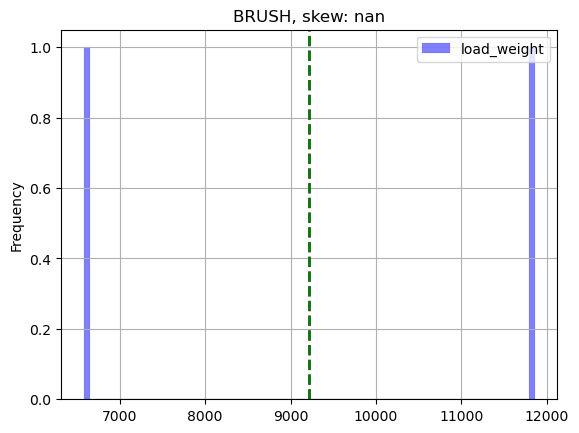

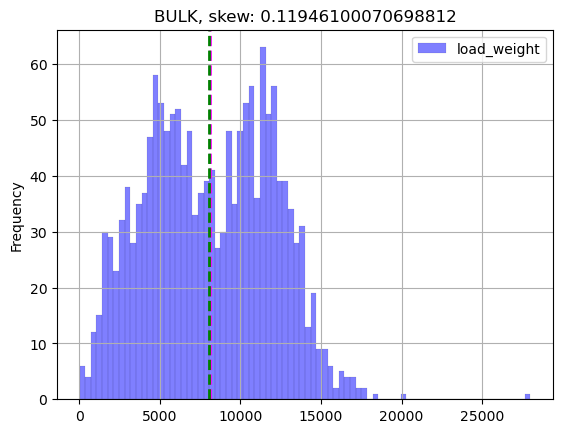

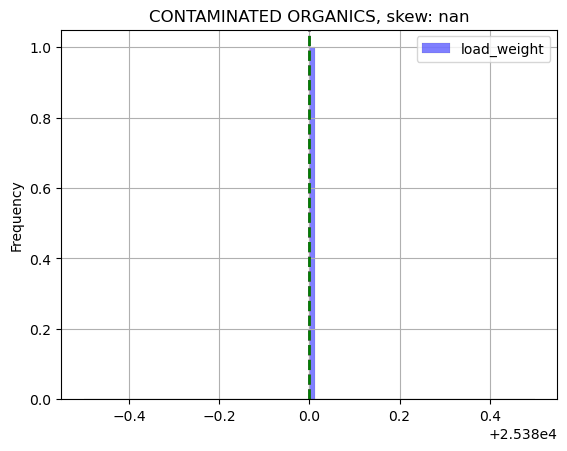

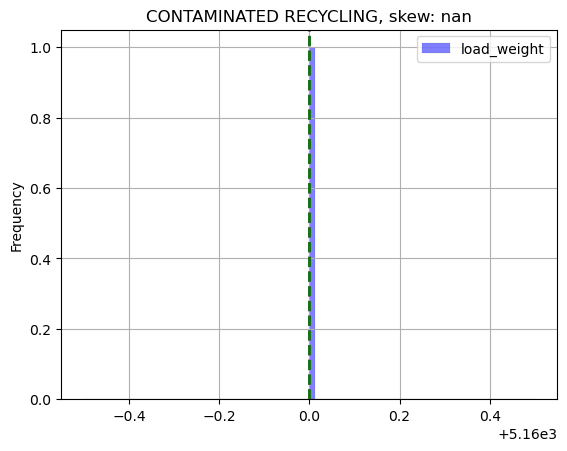

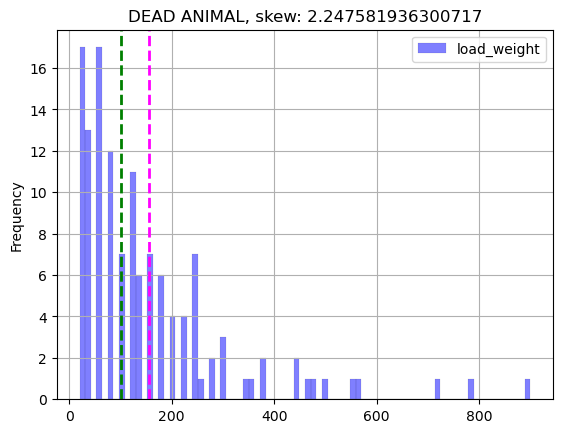

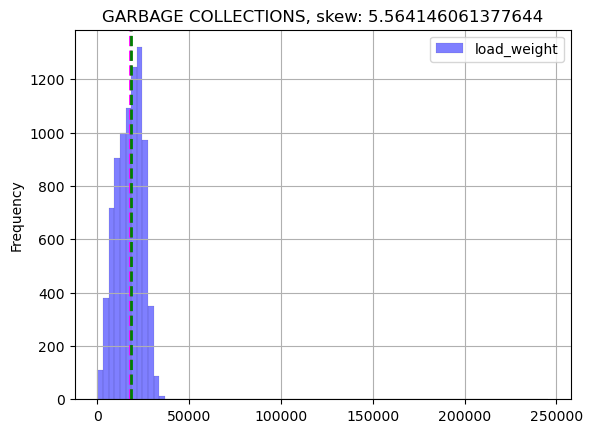

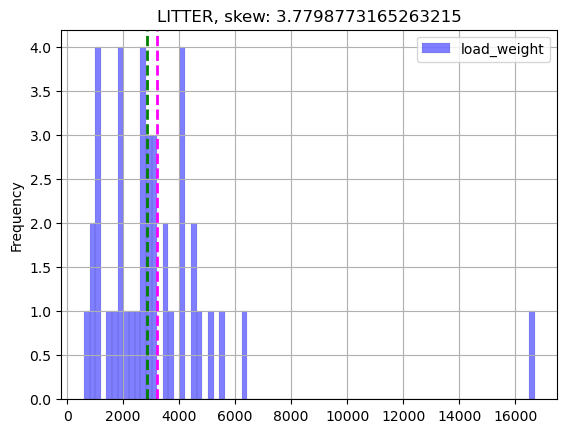

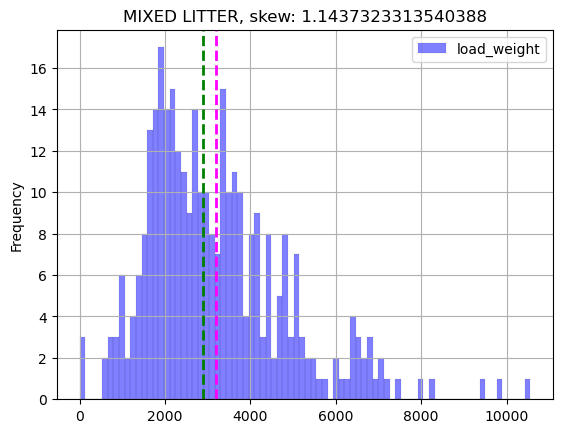

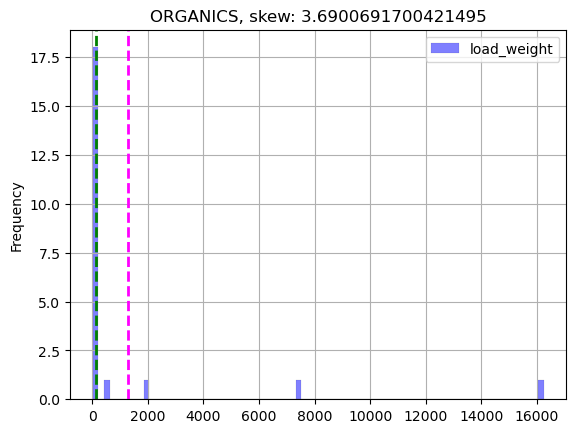

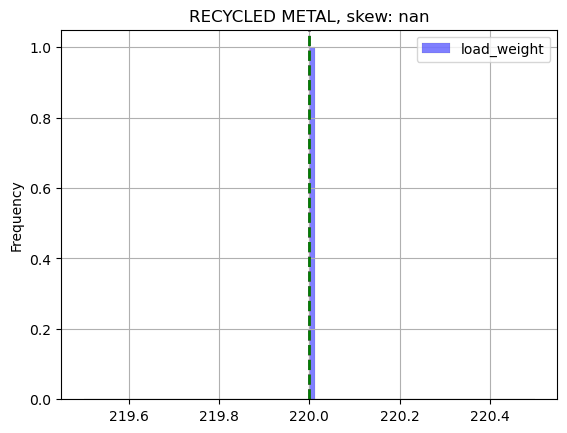

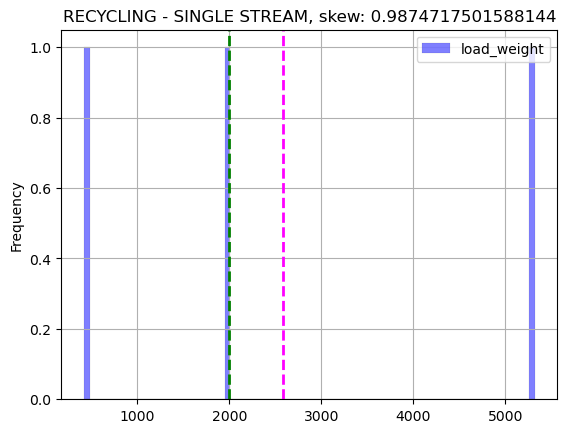

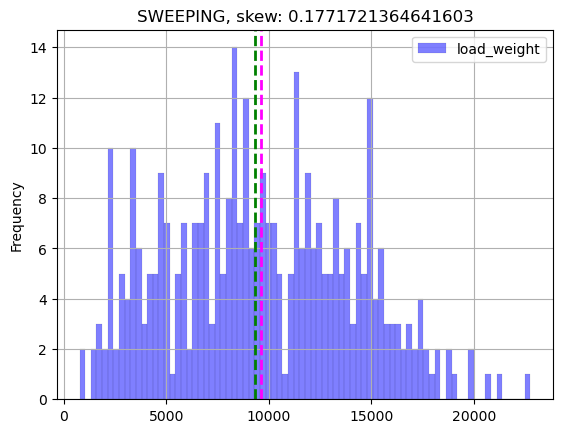

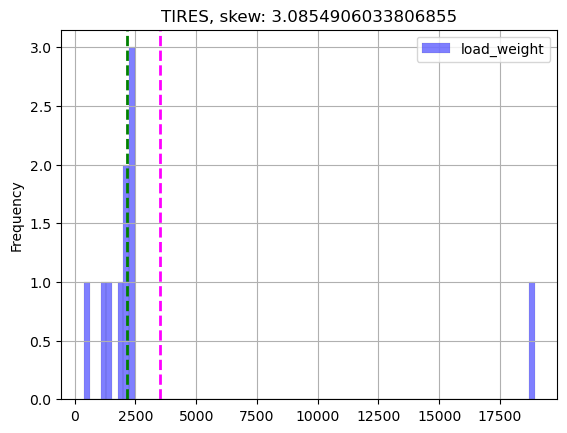

In [31]:
df_landfill = df[['load_type','load_weight']][df.dropoff_site=='TDS LANDFILL'].groupby('load_type')

# plot histograms
ax = df_landfill.plot.hist(bins=80, color='blue',grid=True,alpha=0.5,linewidth=0.1,edgecolor='black')

# menghitung skewness untuk tiap jenis sampah pada site tds landfill
df_hist_skew = df_landfill.skew()

# menghitung mean untuk tiap jenis sampah pada site tds landfill
df_hist_mean = df_landfill.mean()

# menghitung median untuk tiap jenis sampah pada site tds landfill
df_hist_median = df_landfill.median()

# menghitung std untuk tiap jenis sampah pada site tds landfill
df_hist_std = df_landfill.std()

# set title for each histogram & print each skewness
for index, hist in enumerate(ax):
    hist.axvline(df_landfill.mean().squeeze()[index], color='magenta', linestyle='dashed', linewidth=2)
    hist.axvline(df_landfill.median().squeeze()[index], color='green', linestyle='dashed', linewidth=2)
    hist.set_title(titles[index] + ', skew: {}'.format(df_hist_skew.loc[:,'load_weight'][index]))
    print(titles[index]+"\n")
    print('Skew\t: {}'.format(df_hist_skew.loc[:,'load_weight'][index]))
    print('Mean\t: {}'.format(df_hist_mean.loc[:,'load_weight'][index]))
    print('Median\t: {}'.format(df_hist_median.loc[:,'load_weight'][index]))
    print('Std\t: {}\n'.format(df_hist_std.loc[:,'load_weight'][index]))

Dari semua jenis sampah pada TDS landfill, terdapat beberapa jenis kemiringan data, diantaranya:<br>

Kemiringan yang tinggi/highly skewed (<-1 atau >1):<br>
- DEAD ANIMAL (2.24)
- GARBAGE COLLECTIONS (5.56)
- LITTER (3.77)
- MIXED LITTER (1.14)
- ORGANICS (3.69)
- TIRES (3.08)

Cukup miring/Moderately Skewed (-1.0 to -0.5 atau 0.5-1.0):<br>
- RECYCLING - SINGLE STREAM (0.98)

Cukup Simetris/Fairly Symmetrical (-0.5-0.5)
- BULK (0.11)
- SWEEPING (0.17)

Untuk jenis sampah dengan kemiringan yang tinggi, besar kemungkinan terdapat outlier pada data tersebut.

### Visualisasi Outlier pada Site TDS Landfill

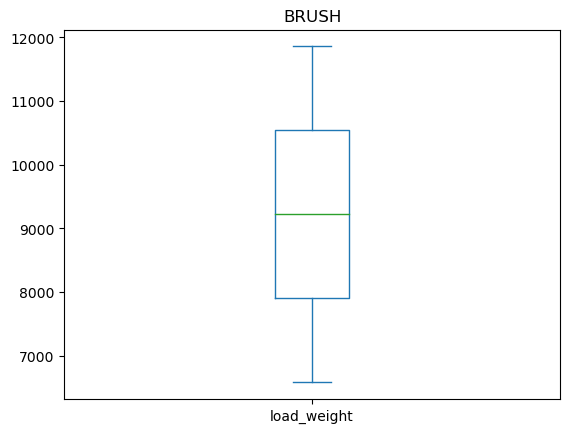

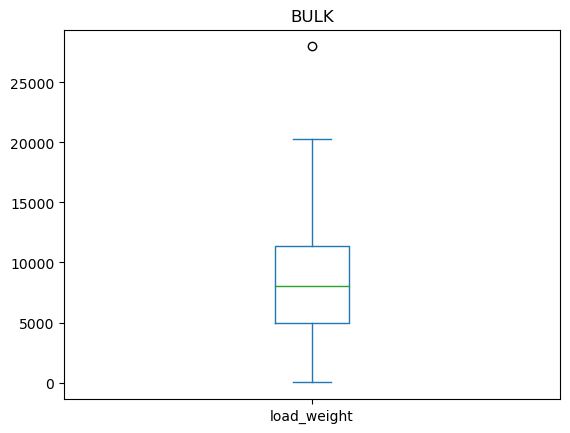

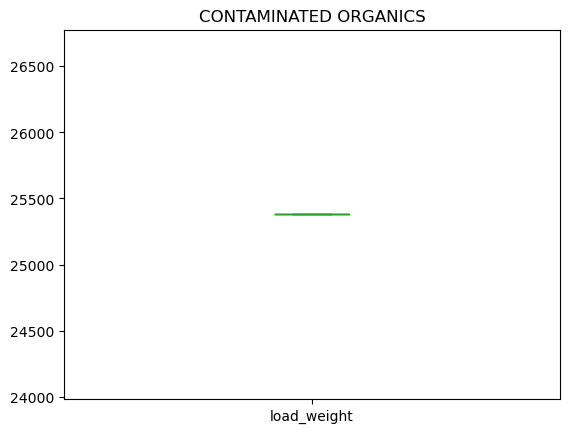

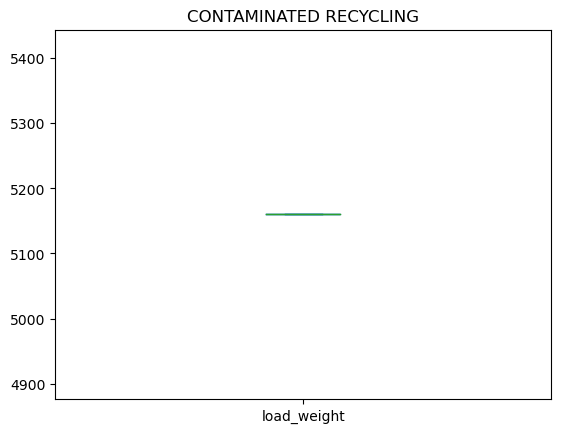

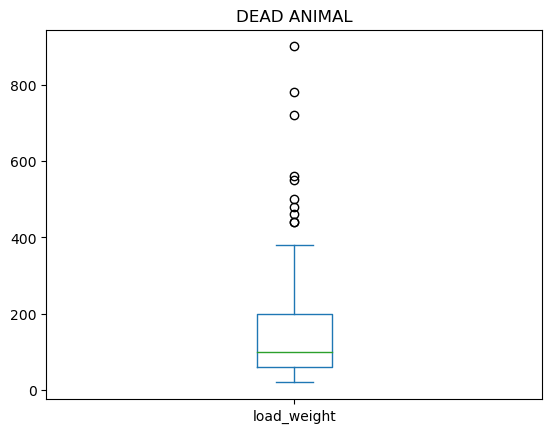

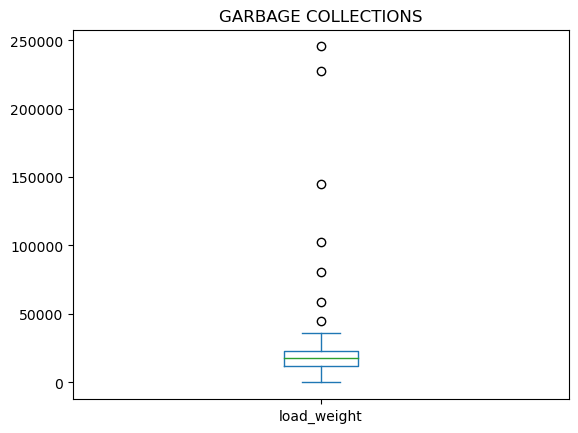

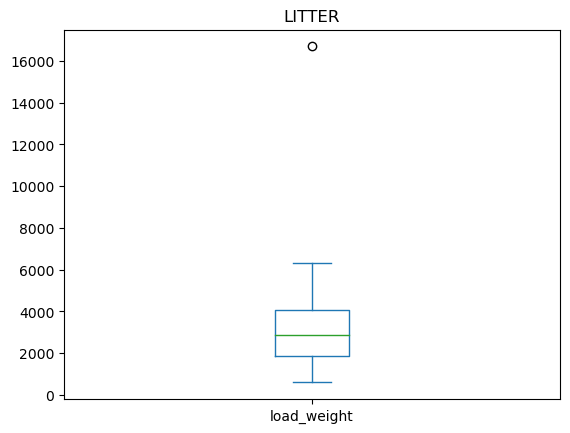

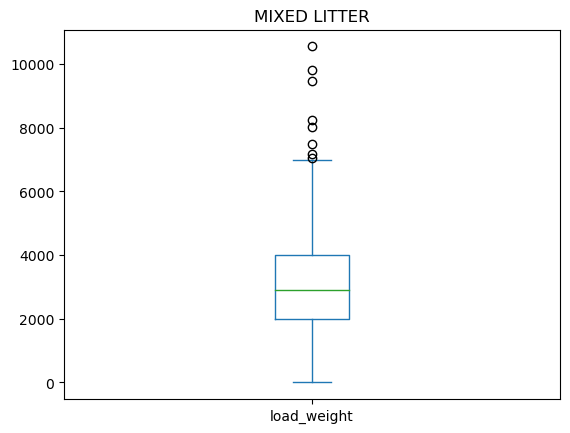

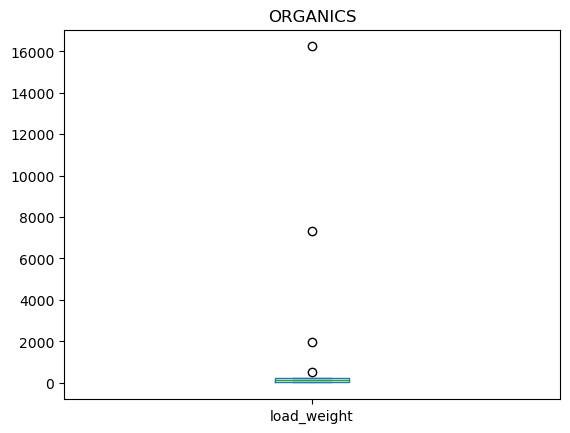

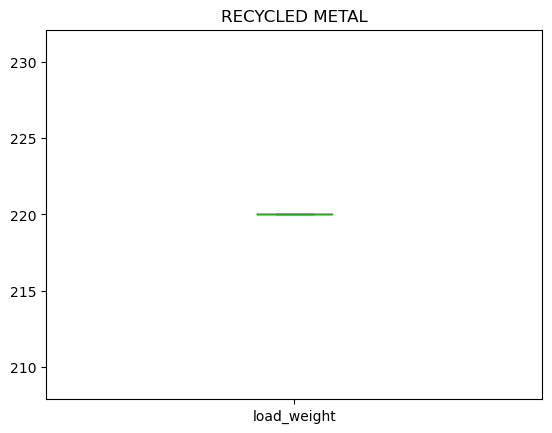

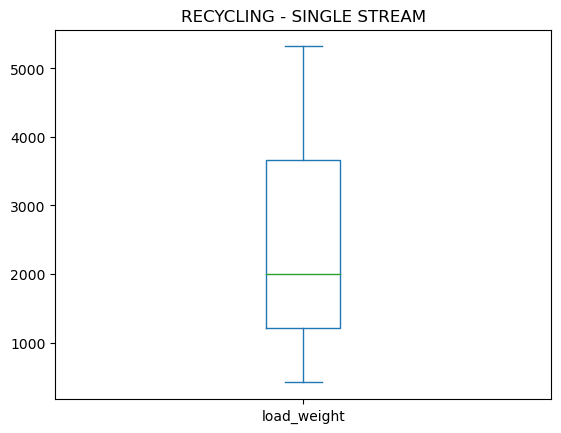

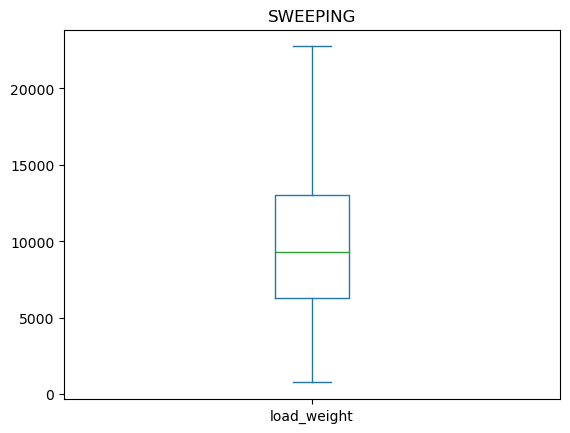

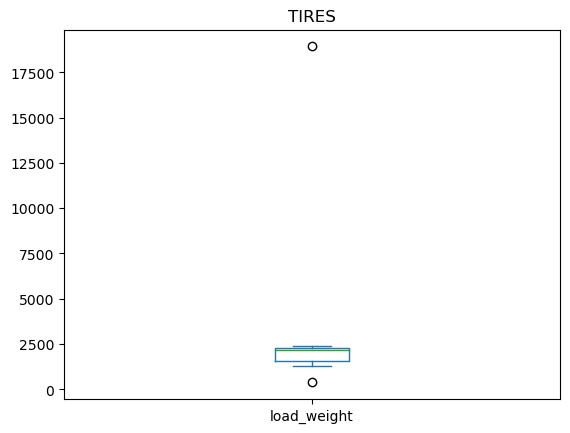

In [32]:
ax2 = df_landfill.plot(kind='box')
for i in range(len(titles)):
    ax2[i].set_title(titles[i])


Dari boxplot diatas, terdapat outlier pada jenis sampah bulk, dead animal, garbage collection, litter, mixed litter, organics, dan tires

Dari nilai mean dan mediannya:
- Sampah jenis bulk memiliki karakteristik distribusi normal, maka untuk mencari outlier digunakan z-score.

- Sampah jenis garbage collection, dead animal, litter, mixed-litter, organics, dan tires memiliki karakteristik distribusi gamma, maka untuk mencari outlier digunakan tukeys rule.

- Untuk tipe sampah recycling single stream, penulis masih perlu menganalisa lebih lanjut, dengan pertimbangan: pada boxplot tidak terlihat outlier namun pada distribusi terlihat cukup miring dengan skewness score 0.98, nilai mean dan median yang relatif berjauhan, dan nilai standar deviasi yang tinggi.

### Handling Outlier pada Site TDS Landfill

#### Handling Outlier dengan Distribusi Normal

Handling outlier pada jenis sampah BULK

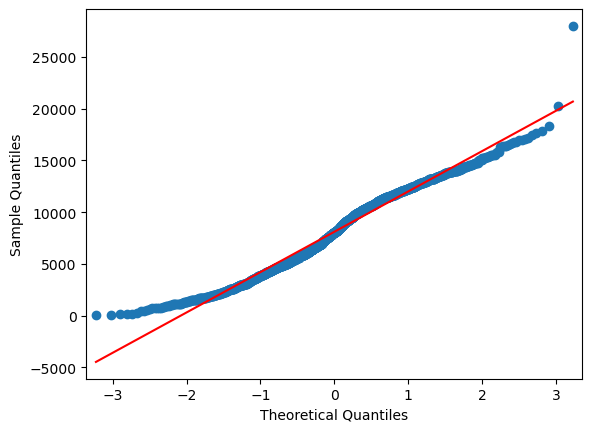

In [33]:
my_data = df_landfill.get_group('BULK').loc[:,'load_weight']
sm.qqplot(my_data,line='s')
pylab.show()

In [34]:
# menyimpan total entri data site TDS LANDFILL
total_len_landfill = len(df[df['dropoff_site']=='TDS LANDFILL'].index)

Menghitung jumlah outlier untuk jenis sampah dengan distribusi normal

In [35]:
df_landfill.get_group('BULK').loc[:,'load_weight']

# Get Z-Score
df['Z-Score'] = stats.zscore(df_landfill.get_group('BULK').loc[:,'load_weight'])
outlier_bulk = df['Z-Score'][(df['Z-Score']>3) | (df['Z-Score']<-3)]

percentage_out_bulk = outlier_bulk.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah bulk: {0:.2f}%".format(percentage_out_bulk))

Persentase outlier site TDS-Landfill dengan jenis sampah bulk: 0.02%


#### Handling Outlier dengan Distribusi Tidak Normal

Handling outlier pada jenis sampah GARBAGE COLLECTIONS

In [36]:
df_landfill_gc = df_landfill.get_group('GARBAGE COLLECTIONS').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_gc.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_gc = df_landfill_gc[(df_landfill_gc < lower_limit) | (df_landfill_gc > upper_limit)]

percentage_out_gc = outlier_gc.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah GARBAGE COLLECTIONS: {0:.2f}%".format(percentage_out_gc))

Persentase outlier site TDS-Landfill dengan jenis sampah GARBAGE COLLECTIONS: 0.07%


Handling outlier pada jenis sampah DEAD ANIMAL

In [37]:
df_landfill_dead_animal = df_landfill.get_group('DEAD ANIMAL').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_dead_animal.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_dead_animal = df_landfill_dead_animal[(df_landfill_dead_animal < lower_limit) | (df_landfill_dead_animal > upper_limit)]

percentage_out_dead_animal = outlier_dead_animal.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah DEAD ANIMAL: {0:.2f}%".format(percentage_out_dead_animal))

Persentase outlier site TDS-Landfill dengan jenis sampah DEAD ANIMAL: 0.09%


In [38]:
df_landfill_litter = df_landfill.get_group('LITTER').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_litter.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_litter = df_landfill_litter[(df_landfill_litter < lower_limit) | (df_landfill_litter > upper_limit)]

percentage_out_litter = outlier_litter.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah LITTER: {0:.2f}%".format(percentage_out_litter))

Persentase outlier site TDS-Landfill dengan jenis sampah LITTER: 0.01%


In [39]:
df_landfill_mixed_litter = df_landfill.get_group('MIXED LITTER').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_mixed_litter.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_mixed_litter = df_landfill_mixed_litter[(df_landfill_mixed_litter < lower_limit) | (df_landfill_mixed_litter > upper_limit)]

percentage_out_mixed_litter = outlier_mixed_litter.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah MIXED LITTER: {0:.2f}%".format(percentage_out_mixed_litter))

Persentase outlier site TDS-Landfill dengan jenis sampah MIXED LITTER: 0.07%


In [40]:
df_landfill_organics = df_landfill.get_group('ORGANICS').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_organics.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_organics = df_landfill_organics[(df_landfill_organics < lower_limit) | (df_landfill_organics > upper_limit)]

percentage_out_organics = outlier_organics.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah ORGANICS: {0:.2f}%".format(percentage_out_organics))

Persentase outlier site TDS-Landfill dengan jenis sampah ORGANICS: 0.04%


In [41]:
df_landfill_tires = df_landfill.get_group('TIRES').loc[:,'load_weight']
Q1,Q2,Q3 = df_landfill_tires.quantile([0.25,0.5,0.75])
IQR = Q3 - Q1 # hitung interquartile range

# filter outlier dengan tukey's rule
upper_limit = Q3 + (1.5*IQR)
lower_limit = Q1 - (1.5*IQR)
outlier_tires = df_landfill_tires[(df_landfill_tires < lower_limit) | (df_landfill_tires > upper_limit)]

percentage_out_tires = outlier_tires.count()/total_len_landfill * 100
print("Persentase outlier site TDS-Landfill dengan jenis sampah TIRES: {0:.2f}%".format(percentage_out_tires))

Persentase outlier site TDS-Landfill dengan jenis sampah TIRES: 0.02%


In [42]:
# menggabungkan semua index outlier pada dataset dalam satu list
outlier_row_list = outlier_bulk.index.to_list() + outlier_gc.index.to_list() + outlier_dead_animal.index.to_list() + outlier_litter.index.to_list()\
     + outlier_mixed_litter.index.to_list() + outlier_organics.index.to_list() + outlier_tires.index.to_list()
total_outlier = len(outlier_row_list) # menghitung jumlah outlier
print("Jumlah outlier: {} data".format(total_outlier))

Jumlah outlier: 34 data


In [43]:
print("Jumlah data sebelum trimming outlier:", len(df.index))#cek jumlah data sebelum drop outlier

Jumlah data sebelum trimming outlier: 26157


#### Membuang Data Outlier

In [44]:
df_clean = df.drop(columns='Z-Score',inplace=True) #drop outlier column wise (kolom z-score sudah tidak lagi diperlukan)
df_clean = df.drop(outlier_row_list) #drop outlier row wise
print("Jumlah data sebelum trimming outlier:", len(df_clean.index))#cek jumlah data setelah drop outlier

Jumlah data sebelum trimming outlier: 26123


In [45]:
df_clean

,report_date,load_time,load_type,load_weight,dropoff_site
0,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,"11,300.00",ONION CREEK
1,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,"11,300.00",ONION CREEK
2,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,"11,300.00",ONION CREEK
3,2021-01-01,2021-01-01 12:00:00 UTC,SWEEPING,"11,300.00",ONION CREEK
4,2021-01-02,2021-01-02 09:24:00 UTC,TIRES,"1,640.00",MRF
...,...,...,...,...,...
26152,2021-07-09,2021-07-09 09:48:00 UTC,BRUSH,"8,240.00",HORNSBY BEND
26153,2021-07-09,2021-07-09 12:02:00 UTC,BRUSH,"4,160.00",HORNSBY BEND
26154,2021-07-09,2021-07-09 11:55:00 UTC,BRUSH,"4,340.00",HORNSBY BEND
26155,2021-07-09,2021-07-09 12:00:00 UTC,LITTER,"1,900.00",TDS LANDFILL


### Total Persentase Outlier di site TDS Landfill

In [46]:
total_percentage_outlier = percentage_out_bulk + percentage_out_gc + percentage_out_dead_animal + percentage_out_litter\
    + percentage_out_mixed_litter + percentage_out_organics + percentage_out_tires

outlier_dataset = outlier_bulk.count() + outlier_gc.count() + outlier_dead_animal.count() + outlier_litter.count()\
    + outlier_mixed_litter.count() + outlier_organics.count() + outlier_tires.count()
total_data = len(df.index)
print("Total outlier {} data".format(total_outlier))
print("Total outlier terhadap site TDS LANDFILL {:.2f}%".format(total_percentage_outlier))
print("Total outlier terhadap dataset {:.4f}%".format(outlier_dataset/total_data))

Total outlier 34 data
Total outlier terhadap site TDS LANDFILL 0.32%
Total outlier terhadap dataset 0.0013%


### Perbandingan Central Tendency Sebelum dan Sesudah Handling Outlier

In [47]:
# previous tds landfill site centrality
df_landfill_prev_central_by_type = df[df['dropoff_site']=='TDS LANDFILL'].groupby(['dropoff_site','load_type']).agg({'load_weight':['mean','median','std']}) #overrall period centrality
df_landfill_prev_central_by_type

load_weight                   
                                              mean    median      std
dropoff_site load_type                                               
TDS LANDFILL BRUSH                        9,220.00  9,220.00 3,733.52
             BULK                         8,109.11  8,030.00 3,901.35
             CONTAMINATED ORGANICS       25,380.00 25,380.00      NaN
             CONTAMINATED RECYCLING       5,160.00  5,160.00      NaN
             DEAD ANIMAL                    154.73    100.00   156.06
             GARBAGE COLLECTIONS         17,618.41 18,140.00 8,015.73
             LITTER                       3,208.00  2,850.00 2,585.52
             MIXED LITTER                 3,196.90  2,900.00 1,663.29
             ORGANICS                     1,273.64    140.00 3,692.53
             RECYCLED METAL                 220.00    220.00      NaN
             RECYCLING - SINGLE STREAM    2,580.00  2,000.00 2,500.96
             SWEEPING                     9,596.33  9,310.00 4,538.07
             TIRES                        3,512.00  2,170.00 5,455.42

In [48]:
# outlier free tds landfill site centrality
df_landfill_outlier_free_central_by_type = df_clean[df_clean['dropoff_site']=='TDS LANDFILL'].groupby(['dropoff_site','load_type']).agg({'load_weight':['mean','median','std']}) #overrall period centrality
df_landfill_outlier_free_central_by_type

load_weight                   
                                              mean    median      std
dropoff_site load_type                                               
TDS LANDFILL BRUSH                        9,220.00  9,220.00 3,733.52
             BULK                         8,088.92  8,020.00 3,859.62
             CONTAMINATED ORGANICS       25,380.00 25,380.00      NaN
             CONTAMINATED RECYCLING       5,160.00  5,160.00      NaN
             DEAD ANIMAL                    119.34    100.00    88.84
             GARBAGE COLLECTIONS         17,522.99 18,120.00 6,994.37
             LITTER                       2,862.05  2,780.00 1,395.57
             MIXED LITTER                 3,065.17  2,860.00 1,442.92
             ORGANICS                       110.00     90.00    74.60
             RECYCLED METAL                 220.00    220.00      NaN
             RECYCLING - SINGLE STREAM    2,580.00  2,000.00 2,500.96
             SWEEPING                     9,596.33  9,310.00 4,538.07
             TIRES                        1,975.00  2,170.00   400.54

Central tendency dari data tanpa outlier terlihat lebih seragam, dapat dilihat dari kedekatan nilai mean dan mediannya, dan secara umum standar deviasinya mengecil.

### Menghitung Range, Variance, dan Standar Deviasi load_weight pada site TDS Landfill

In [49]:
# range
df_clean_range = df_clean['load_weight'][df_clean['dropoff_site']=="TDS LANDFILL"].max()-df_clean['load_weight'][df_clean['dropoff_site']=="TDS LANDFILL"].min()
# variance
df_clean_var = df_clean['load_weight'][df_clean['dropoff_site']=="TDS LANDFILL"].var()
# standar deviasi
df_clean_std = df_clean['load_weight'][df_clean['dropoff_site']=="TDS LANDFILL"].std()

print("Clean TDS Landfill Data\nRange\t\t: {}\nVariance\t: {}\nStandar Deviasi\t: {}\n".format(df_clean_range,df_clean_var,df_clean_std))

Clean TDS Landfill Data
Range		: 35900.0
Variance	: 61518198.81786223
Standar Deviasi	: 7843.353799100371



In [50]:
# range
range_old = df['load_weight'][df['dropoff_site']=="TDS LANDFILL"].max()-df['load_weight'][df['dropoff_site']=="TDS LANDFILL"].min()
# variance
var_old = df['load_weight'][df['dropoff_site']=="TDS LANDFILL"].var()
# standar deviasi
std_old = df['load_weight'][df['dropoff_site']=="TDS LANDFILL"].std()

print("Previous TDS Landfill Data\nRange\t\t: {}\nVariance\t: {}\nStandar Deviasi\t: {}\n".format(range_old,var_old,std_old))

Previous TDS Landfill Data
Range		: 245540.0
Variance	: 73789276.79490957
Standar Deviasi	: 8590.068497684379



Insight kepada pemerintah kota Austin:
- Range, variance, dan standar deviasi pada data yang sudah dibersihkan terlihat mengecil, hal ini menunjukkan distribusi data yang lebih seragam sehingga pengambilan keputusan yang menggunakan data site TDS Landfill sebagai acuan akan lebih akurat/representatif.

## Analisis Kapasitas Penampungan Site Baru dengan Confidence Interval

In [51]:
df_monthly_clean = df_clean.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M')]).sum()
df_monthly_clean_len = len(df_monthly_clean.loc['TDS LANDFILL'].index)
df_monthly_clean

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/1268266306.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly_clean = df_clean.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1M')]).sum()


load_weight
dropoff_site          report_date              
AUSTIN IRON AND METAL 2021-01-31       1,950.00
                      2021-02-28       1,890.00
                      2021-03-31       3,970.00
                      2021-04-30       3,410.00
                      2021-05-31       6,230.00
...                                         ...
TDS LANDFILL          2021-05-31  26,811,500.00
                      2021-06-30  27,422,630.30
                      2021-07-31   6,791,250.00
WESTFIELD             2021-05-31      16,020.00
WILCAB                2021-01-31      11,300.00

[84 rows x 1 columns]

In [52]:
df_monthly_centrality_clean = df_monthly_clean.groupby(['dropoff_site']).agg({'load_weight':['mean','median','std']}) #monthly centrality
df_monthly_centrality_clean.sort_values(by=('load_weight','mean'),ascending=False) # mengurutkan site dari nilai mean tertinggi

load_weight                           
                               mean        median          std
dropoff_site                                                  
TDS LANDFILL          23,017,223.65 25,683,700.00 7,376,741.18
ORGANICS BY GOSH       9,715,443.71  8,715,460.00 6,659,087.54
BALCONES RECYCLING     5,187,981.43  5,944,230.00 2,117,444.52
TDS - MRF              4,157,754.29  4,733,050.00 1,796,368.00
HORNSBY BEND           1,569,202.86  1,660,200.00   567,745.82
ONION CREEK            1,312,414.29  1,344,700.00   523,570.54
GREAT NORTHERN           167,624.00     76,860.00   157,425.62
PARK CENTER              141,250.00    113,000.00   112,717.15
ON ROUTE HIGH DUMP       131,982.86    124,300.00   103,686.47
MRF                       43,199.57     49,900.00    20,962.13
PARK BEND                 17,846.67     20,400.00     7,924.75
WESTFIELD                 16,020.00     16,020.00          NaN
WILCAB                    11,300.00     11,300.00          NaN
ST. EDWARDS               11,300.00     11,300.00          NaN
BALCONES WOODS             8,460.00      8,460.00          NaN
AUSTIN WOOD RECYCLING      4,050.00      4,050.00     2,418.31
AUSTIN IRON AND METAL      3,222.86      3,410.00     1,765.36
STEINER LANDFILL             780.00        780.00          NaN

In [53]:
df_tds_monthly_clean = df_monthly_centrality_clean.loc["TDS LANDFILL"]['load_weight']
df_tds_monthly_clean

mean     23,017,223.65
median   25,683,700.00
std       7,376,741.18
Name: TDS LANDFILL, dtype: float64

Menghitung kapasitas penampungan sampah yang dibutuhkan site baru

In [54]:
# menghitung expected value given confidence interval (95%)
ci = stats.norm.interval(0.95, df_tds_monthly_clean['mean'], df_tds_monthly_clean['std']/np.sqrt(df_monthly_clean_len)) # two tail
print(f'the expected value of the population lies between {ci[0]} and {ci[1]}')

the expected value of the population lies between 17552557.720819265 and 28481889.57615217


- Penulis menggunakan data rata-rata akumulasi sampah bulanan (tak peduli jenis sampahnya) pada satu site saja yaitu TDS Landfill dengan alasan rata-rata akumulasi sampah bulanan terbesar ada pada site tersebut, selain itu penulis juga sudah membersihkan outliernya sehingga olahan data yang mengacu pada site tersebut diharapkan lebih akurat guna menghasilkan keputusan yang tepat. 
- Dengan tingkat kepercayaan 95%, rata-rata penduduk kota Austin menghasilkan sampah bulanan sebesar diantara 17,6 juta dan 28,5 juta kilogram sampah.
- Kapasitas site yang akan dibangun hendaknya disesuaikan dengan data ini.

## Analisis Uji Hipotesis

Penulis melihat site Hornsby Bend dan Onion Creek memiliki kemiripan data akumulasi sampah bulanan, namun penulis ingin mengetahui apakah rata rata sampah harian mereka juga demikian, jika demikian apakah perbedaannya tersebut signifikan/tidak.

- H0 = Rata-rata akumulasi sampah harian site HORNSBY BEND sama dengan site ONION CREEK.
- H1 = Rata-rata akumulasi sampah harian site HORNSBY BEND tidak sama dengan site ONION CREEK.
- Confidence threshold yang akan digunakan sebesar 95%

In [55]:
df_daily_clean = df_clean.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1D')]).sum()

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/3719375900.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily_clean = df_clean.groupby(['dropoff_site',pd.Grouper(key='report_date',freq='1D')]).sum()


In [56]:
df_daily_hornsby_clean = df_daily_clean.loc['HORNSBY BEND']
df_daily_hornsby_clean

,load_weight
report_date,
2021-01-02,"78,820.00"
2021-01-04,"180,920.00"
2021-01-05,"95,880.00"
2021-01-06,"156,400.00"
2021-01-07,"107,600.00"
...,...
2021-07-05,"26,520.00"
2021-07-06,"76,220.00"
2021-07-07,"53,220.00"


In [57]:
df_daily_onion_clean = df_daily_clean.loc['ONION CREEK']
df_daily_onion_clean

,load_weight
report_date,
2021-01-01,"45,200.00"
2021-01-02,"33,900.00"
2021-01-05,"11,300.00"
2021-01-06,"56,500.00"
2021-01-07,"79,100.00"
...,...
2021-07-03,"56,500.00"
2021-07-06,"67,800.00"
2021-07-07,"101,700.00"


In [58]:
df_daily_hornsby_clean.mean() #rata2 sampah harian hornsby bend

load_weight   76,280.69
dtype: float64

In [59]:
df_daily_onion_clean.mean() #rata2 sampah harian onion creek

load_weight   65,620.71
dtype: float64

In [60]:
t_stat, p_val = stats.ttest_ind(df_daily_hornsby_clean,df_daily_onion_clean)
print('P-value:',p_val[0]) #the p-value isn't divided by 2 since the output is two-sided p-value
print('t-statistics:',t_stat[0])

P-value: 0.02031767830921908
t-statistics: 2.3336339594867987


Terlihat diatas P-value < P-value threshold (0.05) maka reject H0

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/2988145986.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_daily_hornsby_clean, label="Hornsby Bend's Average Trash Load a Day *Pop",color='blue')
/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/2988145986.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwasko

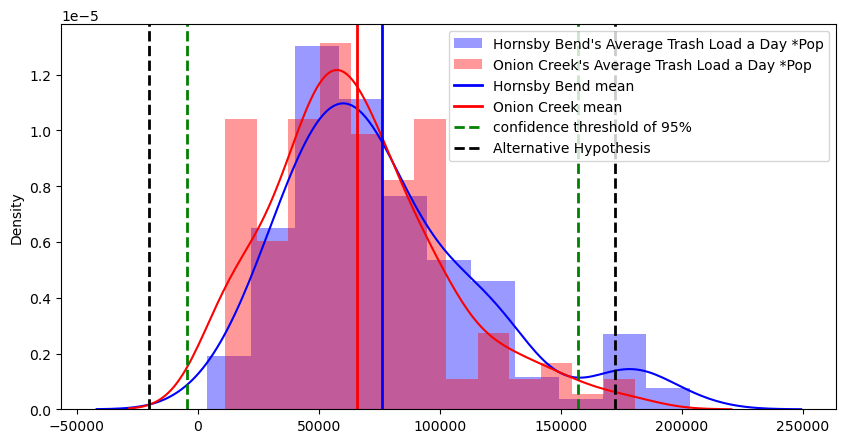

In [61]:
ci = stats.norm.interval(0.95, df_daily_hornsby_clean.mean(), df_daily_hornsby_clean.std())
plt.figure(figsize=(10,5))
sns.distplot(df_daily_hornsby_clean, label="Hornsby Bend's Average Trash Load a Day *Pop",color='blue')
sns.distplot(df_daily_onion_clean, label="Onion Creek's Average Trash Load a Day *Pop",color='red')

plt.axvline(df_daily_hornsby_clean.mean()[0], color='blue', linewidth=2, label='Hornsby Bend mean')
plt.axvline(df_daily_onion_clean.mean()[0], color='red',  linewidth=2, label='Onion Creek mean')

plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=2, label='confidence threshold of 95%')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=2)

plt.axvline(df_daily_hornsby_clean.mean()[0]+t_stat[0]*df_daily_hornsby_clean.std()[0], color='black', linestyle='dashed', linewidth=2, label = 'Alternative Hypothesis')
plt.axvline(df_daily_hornsby_clean.mean()[0]-t_stat[0]*df_daily_hornsby_clean.std()[0], color='black', linestyle='dashed', linewidth=2)

plt.legend()

Dari data dan grafik diatas penulis berkesimpulan dengan tingkat keyakinan 95% bahwa: rata-rata akumulasi sampah harian pada kedua site berbeda secara signifikan.

## Tanya Jawab Terkait Analisis

Teknik apa yang kamu pilih untuk handling outlier? jelaskan alasannya!
>Teknik yang dipilih adalah Trimming dengan bantuan Z-Score untuk data dengan distribusi normal dan Tukey's Rule untuk data dengan distribusi tidak normal. Trimming dilakukan dengan alasan total persentase outlier yang didapatkan terhadap keseluruhan dataset relatif sangat kecil yakni 0.0013% dan terhadap data site khusus TDS Landfill sebesar 0.32%. Dengan outlier sekecil ini, masih ada data asli yang masih utuh sebanyak lebih dari 99%, sehingga penulis meyakini data yang telah terpangkas tetaplah representatif dari kondisi situasi aslinya.

Apa konsep dibalik confidence interval sehingga kita dapat menggunakannya untuk menyelesaikan langkah pada nomor 7?
>Confidence interval menunjukkan probabilitas suatu nilai akan jatuh diantara 2 nilai, konsep ini dapat digunakan untuk mengestimasi kapasitas minimum dan maksimum pembangunan site baru.

Jelaskan jenis uji hipotesis apa yang kamu terapkan dan mengapa?
>Uji hipotesis yang diterapkan menggunakan *Two Samples Independent Two Tailed Hypothesis Testing*, karena penulis mengunakan data dari 2 site yang berbeda dan uji hipotesis ini dapat menunjukkan seberapa signifikan perbedaan kedua buah data.

# Problem 2 (Math/Calculus)

## Description

### Objective
- Memprediksi muatan sampah dalam kg di kota Austin pada tanggal 10 Juli 2021


### Problem Statement

- Mencari jumlah muatan sampah pada hari sebelumnya
- Mengolah data muatan sampah pada hari sebelumnya untuk memprediksi jumlah muatan sampah di masa depan

### Prediksi Muatan Sampah 10 Juli 2021

In [62]:
df_gb_date = df_clean.groupby('report_date').sum()['load_weight']

/var/folders/lv/63lr74g926b4flfb_7npy3m40000gn/T/ipykernel_50417/1076130265.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_gb_date = df_clean.groupby('report_date').sum()['load_weight']


In [63]:
V = np.gradient(df_gb_date,range(len(df_gb_date)))

In [64]:
v = np.abs(V[-1]) #ambil gradien terakhir

In [65]:
# jumlah muatan sampah pada 9 Juli 2021
load_today = df_gb_date[-1]
print(f'Total muatan sampah 9 Juli 2021 sebesar {load_today:,} kg')

Total muatan sampah 9 Juli 2021 sebesar 176,840.0 kg


In [66]:
# prediksi jumlah muatan sampah pada hari esok (10 Juli 2021)
load_tomorrow = load_today + v*1

# jumlah muatan sampah pada 10 Juli 2021
print(f'Prediksi total muatan sampah pada 10 Juli 2021 sebesar {load_tomorrow:,} kg')

Prediksi total muatan sampah pada 10 Juli 2021 sebesar 1,513,950.0 kg


Untuk menghitung turunan pertama dapat digunakan metode simbolik dan numerik, untuk kasus ini, teknik apa yang kamu gunakan? 
>Penulis menggunakan teknik numerik.


Apakah kamu membutuhkan fungsi matematis untuk menghitung turunannya? (ya/tidak) berikan alasanmu!
>Ya, penulis membutuhkan fungsi matematis np.gradient() untuk menghitung turunannya.

Berapa load weight yang kamu perkirakan di hari esok (10 Juli 2021)?
>Penulis memperkirakan total muatan sampah pada hari esok sebesar 1,513,950.0 kg

### Kesimpulan, Hasil, dan Analisis Keseluruhan
- Untuk mendapatkan insight dari suatu data, penting untuk memastikan bahwa data tersebut bersih dari noise (missing value & outlier).
- Central tendency menunjukkan karakteristik distribusi suatu data dan distribusi data dapat dijadikan acuan untuk mengetahui bagaimana data tersebut dapat diolah.
- Secara sekilas site Hornsby Bend dan Onion Creek memiliki rata-rata muatan sampah bulanan yang terlihat tidak berbeda jauh, namun uji hipotesis menunjukkan untuk rata-rata muatan hariannya berbeda secara signifikan.
- Prediksi total muatan sampah pada 10 Juli 2021 sebesar 1,513,950.0 kg.
- Penerapan ilmu statistika dan matematika pada data dapat memberikan insight dan perspekstif baru terhadap situasi yang sudah terjadi dan bahkan yang mungkin akan terjadi.

### Kesimpulan dan Saran Untuk Pemerintah Kota
- Berdasarkan hasil olah data muatan sampah bulanan, penduduk kota Austin rata-rata menghasilkan sampah bulanan sebesar 17,6 juta hingga 28,5 juta kg sampah. Oleh karena itu, penulis menyarankan pemerintah untuk membangun site baru dengan kapasitas minimal yang dapat menampung 17,6 juta kg sampah tiap bulannya.